# Food Classifier

### In this project we will be using CNN models to predict the food in images.

In this subset, we will be using "seafood", which includes 4 classes.

This notebook was run in Google Colab and is best run using GPUs as the data augmentation section takes quite some time to run.

## Importing libraries

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from numpy.random import seed

seed(1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D,
                                     SeparableConv2D, ReLU, MaxPooling2D, Add, Input,
                                     BatchNormalization, MaxPool2D, GlobalAvgPool2D,
                                     RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception, decode_predictions, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims


from PIL import Image
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import requests
import datetime
import os

## Reading in the data

In [ ]:
# loading in Google Drive to retrieve the dataset(s)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# creating a path variable for the data subset we'll be modeling on
img_path = "/content/drive/My Drive/Capstone/food-11/images/sides/seafood"
img_size = 299
img_size_tup = (299, 299)

# loading the images from the path into a train_data variable while resizing the images and splitting the data
# color mode will be 'rgb' which is 3 colors
# labels are 'categorical' since there are more than 2 categories
train_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path, 
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=(299, 299),
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='training',
          # interpolation='bilinear',
          # follow_links=False,
          # crop_to_aspect_ratio=True
)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.


In [ ]:
# loading the images for validation from the above split into a test_data variable while resizing same as above 

# directory_imgs = "/content/drive/My Drive/Capstone/food-11/validation"

test_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path,
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=(299, 299),
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='validation',
          # interpolation='bilinear',
          # follow_links=False,
          # crop_to_aspect_ratio=True
)

Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [ ]:
# looking at our train_data variable to see shape and type
train_data

<BatchDataset shapes: ((None, 299, 299, 3), (None, 4)), types: (tf.float32, tf.float32)>

In [ ]:
# creating variable for class names
class_names = test_data.class_names

# creating variable for number of classes
n_classes = len(train_data.class_names)
n_classes, class_names

(4, ['mussels', 'oysters', 'sashimi', 'scallops'])

# EDA & Preprocessing the Data

In [ ]:
# function for preprocessing our data into X, y as numpy arrays that are rescaled between 0-1
def preprocess_img_input(batch_dataset):
    for images, labels in batch_dataset.take(1):  # only take first element of dataset
        X = images.numpy()
        y = labels.numpy()

        X /= 255

        return X, y

# splitting our images and labels into X_train and y_train
# converting them to numpy arrays in order to be able to resize them
X_train, y_train = preprocess_img_input(train_data)
X_test, y_test = preprocess_img_input(test_data)
# checking our x and y
X_train[0][0][0], y_train[0]

In [ ]:
# checking the shape of X_train
X_train.shape

(32, 299, 299, 3)

In [ ]:
# checking the shape of y_train
y_train.shape

(32, 4)

In [ ]:
# creating our input variable for our model from the shape of our first X_train set of values
input_shape = X_train[0].shape

# Visualizing the Data

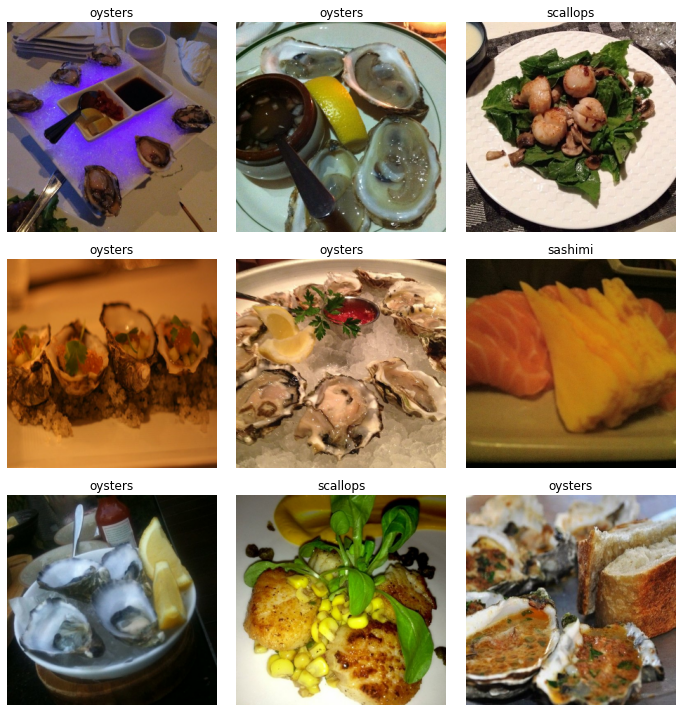

In [ ]:
# code from https://www.tensorflow.org/tutorials/images/classification
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")
        plt.tight_layout()

# Predicting on our Data Using Pre-Trained Model

[('n01943899', 'conch', 0.30912286),
 ('n12768682', 'buckeye', 0.14657593),
 ('n13054560', 'bolete', 0.14194836),
 ('n07693725', 'bagel', 0.111714736),
 ('n07734744', 'mushroom', 0.04367162)]

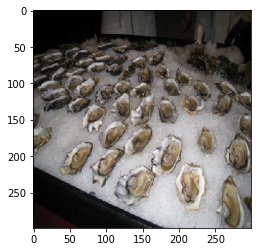

In [ ]:
# code from https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras
# visualizing a prediction on one of our images using Xception and imagenet

# instantiating the Xception pre-trained weights model
model = Xception(weights='imagenet')
# our image path to one of our dataset's images
img_path_single = "/content/drive/My Drive/Capstone/food-11/images/sides/seafood/oysters/14634.jpg"
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path_single, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
plt.imshow(img)
# decoding the results into a list of tuples (class, description, probability)
decode_predictions(preds, top=5)[0]

Our pre-trained model Xception (which was also trained on food images as well as other classes) is predicting oysters as conches, which isn't bad but isn't quite accurate. These pre-trained models will serve as the base for our model to try to get our predictions right.

# Modeling with Neural Nets & Pre-trained Weights

## Modeling with Xception Pretrained Model

In [ ]:
# code help: https://keras.io/api/applications/
# code help: https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

# creating a learning rate schedule to use with our optimizer in our model
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7, 
    decay_steps=10000,
    decay_rate=0.7)

# creating the base pre-trained model
X_model = Xception(weights='imagenet', include_top=False)

# freezing the layers
for layer in X_model.layers:
    layer.trainable = False

# adding a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# adding a fully-connected layer
x = Dense(32, activation='relu')(x)
# and a logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=X_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
early_stop = EarlyStopping(mode='auto', patience=13)

# fitting and running our model
X_results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, steps_per_epoch=112, callbacks=early_stop, workers=4)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 4s 4s/step - loss: 1.3562 - accuracy: 0.4375 - val_loss: 1.3185 - val_accuracy: 0.3125
Epoch 2/100
1/1 [==============================] - 0s 289ms/step - loss: 1.1436 - accuracy: 0.5312 - val_loss: 1.2179 - val_accuracy: 0.3750
Epoch 3/100
1/1 [==============================] - 0s 293ms/step - loss: 0.9199 - accuracy: 0.7188 - val_loss: 1.0040 - val_accuracy: 0.7188
Epoch 4/100
1/1 [==============================] - 0s 290ms/step - loss: 0.6499 - accuracy: 1.0000 - val_loss: 0.7832 - val_accuracy: 0.7812
Epoch 5/100
1/1 [==============================] - 0s 294ms/step - loss: 0.3936 - accuracy: 1.0000 - val_loss: 0.6568 - val_accuracy: 0.8125
Epoch 6/100
1/1 [==============================] - 0s 289ms/step - loss: 0.2190 - accuracy: 0.9688 - val_loss: 0.6141 - val_accuracy: 0.7812
Epoch 7/100
1/1 [==============================] - 0s 299ms/step - loss: 0.1141 - accuracy: 1.0000 - val_loss: 0.6050 - val_accuracy: 0.7812
Epoch 8/100
1/1 [===========

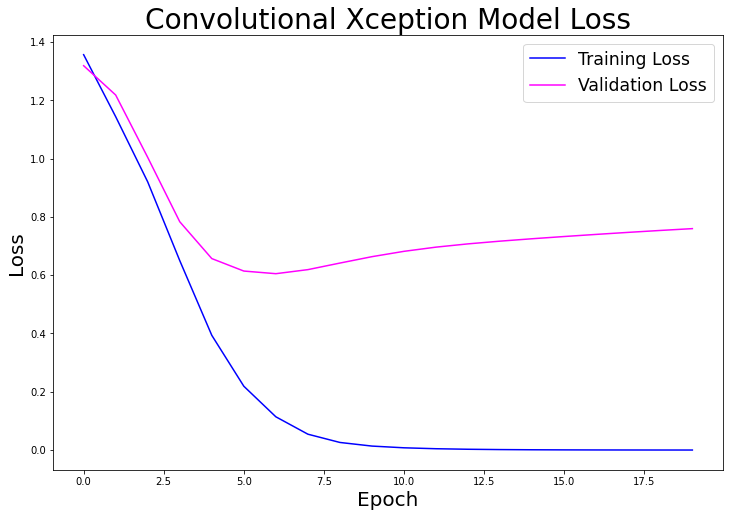

In [ ]:
# plotting our loss for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['loss'], label='Training Loss', color='blue')
plt.plot(X_results.history['val_loss'], label='Validation Loss', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_loss_seafood.png', bbox_inches='tight');

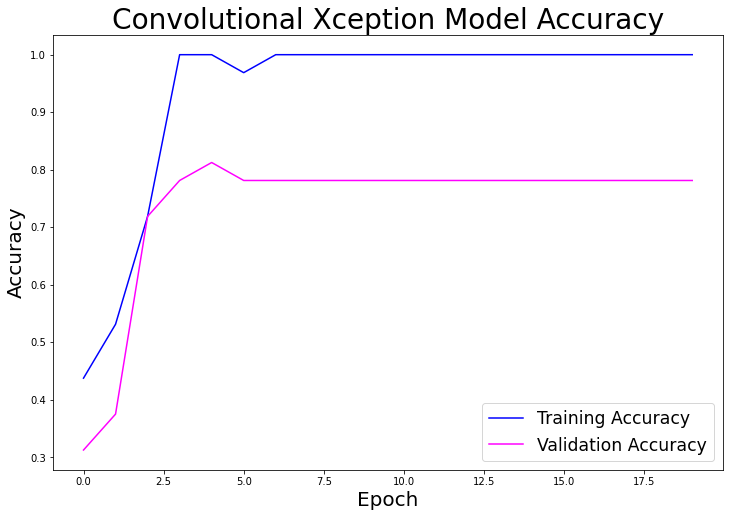

In [ ]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(X_results.history['val_accuracy'], label='Validation Accuracy', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('X_accuracy_seafood.png', bbox_inches='tight');

In [ ]:
# evaluating on test data
X_score = model.evaluate(X_test, y_test, verbose=1)

X_labels = model.metrics_names

# printing Xception scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')

1/1 [==============================] - 0s 157ms/step - loss: 0.7596 - accuracy: 0.7812
Xception loss  : 0.7596014738082886
Xception accuracy   : 0.78125


** Interpretation **
The Xception pre=trained model is doing pretty well on this subset, with 81% accuracy on testing data (100% on training).

In [ ]:
# saving the model
from tensorflow.keras.models import load_model, clone_model
model.save("Xception_model_seafood.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
## code from lesson 9.04
# making predictions on X_test
preds_1 = np.argmax(model.predict(X_test), axis = 1)

# saving predictions to dataframe & output to .csv
X_test_pred_df_1 = pd.DataFrame({
    'Label': preds_1,
    'ImageId': range(1,X_test.shape[0] + 1)
})
X_test_pred_df_1.to_csv('X_preds_seafood.csv', index=False)

In [ ]:
# loading the model back in to use to improve our model
X_2 = load_model('Xception_model_seafood.h5')

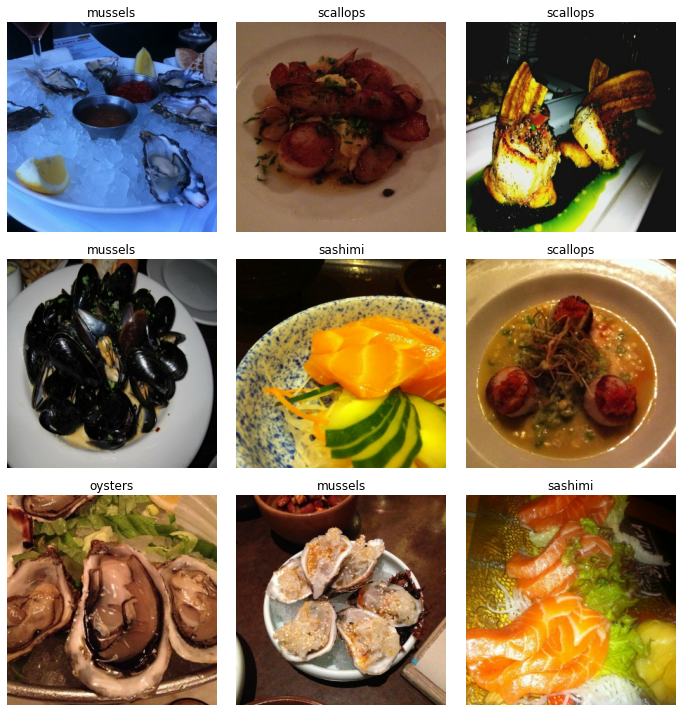

In [ ]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(X_2.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()

Our first model isn't bad with about 81% accuracy but doesn't do great as we can see with the above predictions. Below we will try data augmentation to improve our model's preformance.

In [ ]:
# https://github.com/hbhasin/Image-Recognition-with-Deep-Learning/blob/master/Image%20Classification%20with%20Transfer%20Learning.md
# preprocessing our data using data augmentation


# data pre-processing for training
train_datagen =  ImageDataGenerator( 
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 0.25,
    zoom_range = 0.25,
    brightness_range=[0.6,1.0],
    fill_mode = 'nearest',
    horizontal_flip = True,
    validation_split=0.2)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 0.25,
    zoom_range = 0.25,
    brightness_range=[0.6,1.0],
    fill_mode = 'nearest',
    horizontal_flip = True,
    validation_split=0.2)


# generate and store training data
train_generator = train_datagen.flow_from_directory(
    img_path,
    # class_mode = 'categorical',
    target_size = img_size_tup,
    batch_size = 32, 
    subset='training',
    )

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    img_path,
    # class_mode = 'categorical',
    target_size = img_size_tup,
    batch_size = 32,
    subset='validation')

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


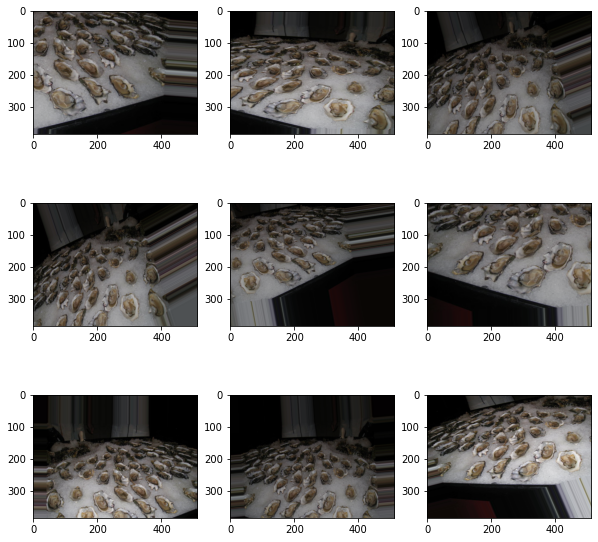

In [ ]:
# code help from https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# visualizing our images with data augmentation implemented
plt.figure(figsize=(10, 10))
# load the image
img = load_img(img_path_single)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

data_augmentation = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = data_augmentation.next()
	# plot raw pixel data
	plt.imshow(batch[0])
# show the figure
plt.show()

In [ ]:
# rerunning our model with data augmentation

# creating learning rate schedule to be used withour optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7, 
    decay_steps=10000,
    decay_rate=0.7)

# creating the base pre-trained model
X_model = Xception(weights='imagenet', include_top=False)


# adding a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# adding a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
# and a logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)
# this is our training model
model = Model(inputs=X_model.input, outputs=predictions)
# freezing our layers
for layer in X_model.layers:
    layer.trainable = False
# compiling the model
model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
# adding early stop
early_stop = EarlyStopping(mode='auto', patience=13)

# fitting the model, logging the results and the training time
now = datetime.datetime.now
t = now()
results_2 = model.fit(
    train_generator,
    epochs=50, 
    steps_per_epoch=112, 
    callbacks=early_stop, 
    workers=8,
    validation_data = validate_generator)
print('Training time: %s' % (now() - t))


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


112/112 [==============================] - 87s 731ms/step - loss: 1.8025 - accuracy: 0.4110 - val_loss: 1.3137 - val_accuracy: 0.4013
Epoch 2/50
112/112 [==============================] - 64s 543ms/step - loss: 1.1807 - accuracy: 0.5159 - val_loss: 0.6300 - val_accuracy: 0.8675
Epoch 3/50
112/112 [==============================] - 67s 547ms/step - loss: 0.6897 - accuracy: 0.7400 - val_loss: 0.4020 - val_accuracy: 0.8900
Epoch 4/50
112/112 [==============================] - 64s 546ms/step - loss: 0.4887 - accuracy: 0.8345 - val_loss: 0.3475 - val_accuracy: 0.8813
Epoch 5/50
112/112 [==============================] - 67s 541ms/step - loss: 0.4397 - accuracy: 0.8580 - val_loss: 0.3737 - val_accuracy: 0.8813
Epoch 6/50
112/112 [==============================] - 64s 543ms/step - loss: 0.3893 - accuracy: 0.8697 - val_loss: 0.2899 - val_accuracy: 0.9125
Epoch 7/50
112/112 [==============================] - 63s 540ms/step - loss: 0.3263 - accuracy: 0.8884 - val_loss: 0.3493 - val_accuracy: 0.9

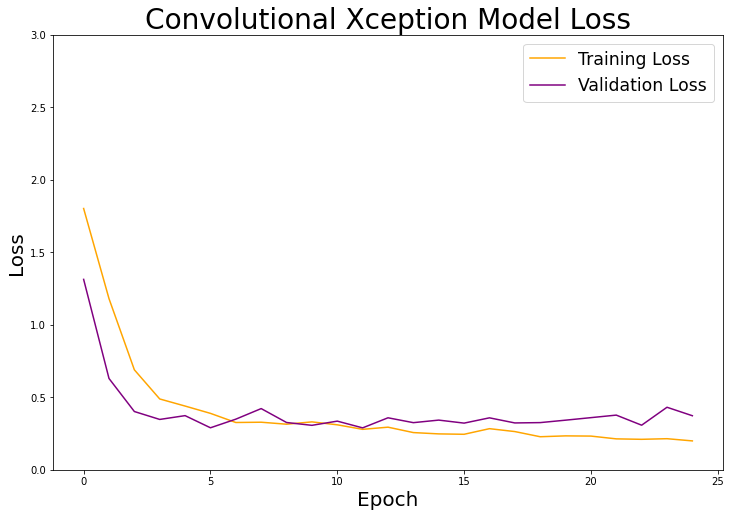

In [ ]:
# plotting our loss for training and testing
plt.figure(figsize=(12,8))
plt.plot(results_2.history['loss'], label='Training Loss', color='orange')
plt.plot(results_2.history['val_loss'], label='Validation Loss', color='purple')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.ylim(0, 3.0)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_loss_seafood_DA.png', bbox_inches='tight');

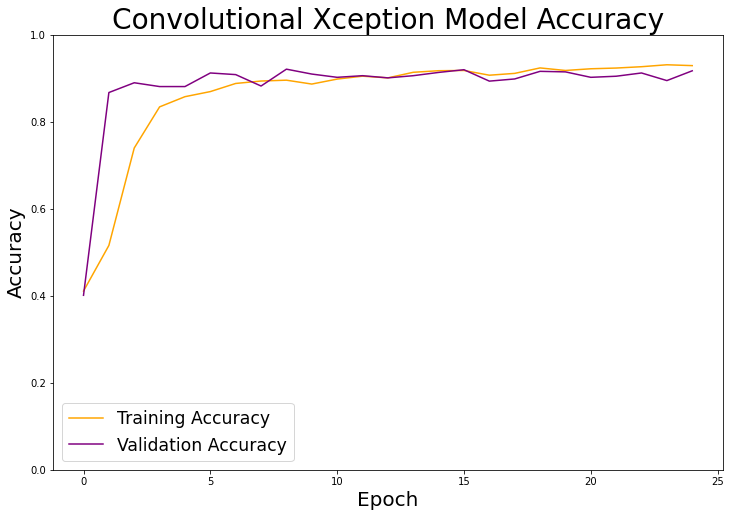

In [ ]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(results_2.history['accuracy'], label='Training Accuracy', color='orange')
plt.plot(results_2.history['val_accuracy'], label='Validation Accuracy', color='purple')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
plt.ylim(0, 1.00)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_seafood_DA.png', bbox_inches='tight');

In [ ]:
# saving the model weights
model.save("/content/drive/My Drive/Capstone/Xception_model_seafood_DA.h5")
pickle.dump(model, open("/content/drive/My Drive/Capstone/Xception_model_seafood_DA.p", 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://3d23d8b3-5c04-49e5-825b-eb7f89fc0256/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# evaluating on test data
X_score_DA = model.evaluate(X_test, y_test, verbose=1)

X_labels_DA = model.metrics_names

# printing Xception scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')
print(f'Xception_DA {X_labels_DA[0]}  : {X_score_DA[0]}')
print(f'Xception_DA {X_labels_DA[1]}   : {X_score_DA[1]}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 0.2477 - accuracy: 0.9688
Xception loss  : 0.7596014738082886
Xception accuracy   : 0.78125
Xception_DA loss  : 0.24767440557479858
Xception_DA accuracy   : 0.96875


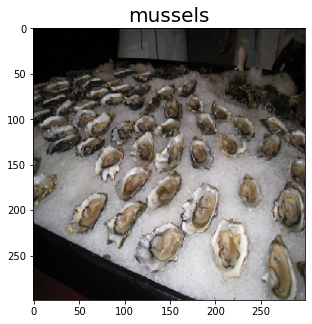

In [ ]:
# visualizing one prediction
plt.figure(figsize=(5,5))
# our image path to one of our dataset's images
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);

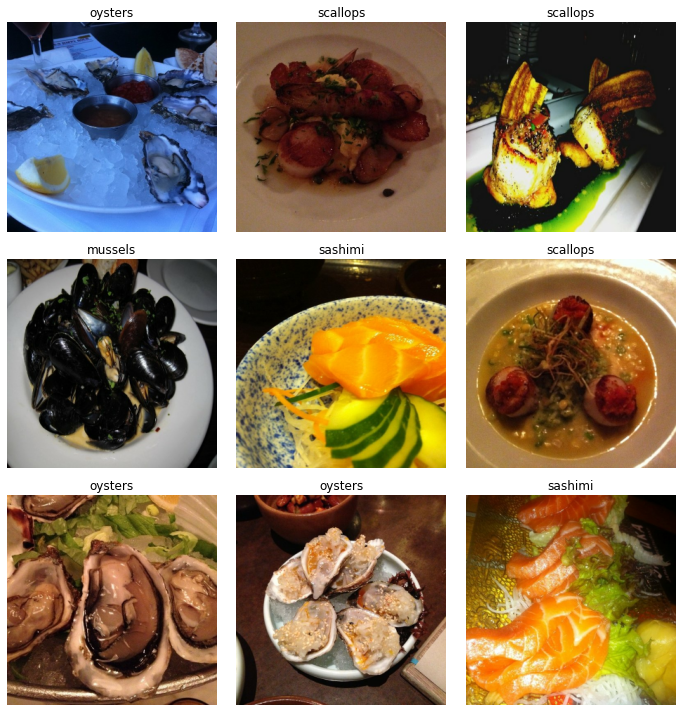

In [ ]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_seafood_preds_DA.png', bbox_inches='tight');

# Conclusions & Recommendations

One again we see the model with data augmentation did much better than without. We were able to achieve 96.9% accuracy on this subset.